# 주어진 기간에 마지막으로 거래된 가격(종가)를 예측

In [1]:
!pip install -q finance-datareader

In [2]:
!pip install -q OpenDartReader

In [3]:
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
import pandas as pd
import numpy as np
import os
import FinanceDataReader as fdr
import OpenDartReader

from tqdm import tqdm

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import datetime

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
path = '/content/drive/My Drive/Colab Notebooks/dacon/주식 종료 가격 예측/'
stock_list = pd.read_csv(path + 'open/stock_list.csv')
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6)) # zfill(n): n자리를 기준으로 모자른 자리는 0으로 채움 ex) 원본 데이터가 12라면 000012로 변환
stock_list

,종목명,종목코드,상장시장
0,삼성전자,005930,KOSPI
1,SK하이닉스,000660,KOSPI
2,NAVER,035420,KOSPI
3,카카오,035720,KOSPI
4,삼성바이오로직스,207940,KOSPI
...,...,...,...
365,맘스터치,220630,KOSDAQ
366,다날,064260,KOSDAQ
367,제이시스메디칼,287410,KOSDAQ
368,크리스에프앤씨,110790,KOSDAQ


In [8]:
# 제출코드 형태 확인 -> 컬럼들이 "종목코드"로 이루어짐, 즉 모든 종목코드의 종가를 예측하는 것
submission = pd.read_csv(path + 'open/sample_submission.csv')
print(submission.shape)
submission # 2021-11-01 ~ 2021-11-05 / 2021-11-29 ~ 2021-12-03

(10, 371)


,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,000670,000720,000810,000880,000990,001230,001440,001450,001740,002380,002790,003000,003090,003380,003410,003490,003670,003800,004000,004020,004170,004370,004490,004800,004990,005250,005290,005300,005380,005385,...,272290,273130,278280,278530,282330,285130,287410,290510,290650,292150,293490,293780,294090,294870,298000,298020,298050,298380,299030,299660,299900,307950,314130,316140,319400,319660,321550,323990,326030,330590,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-11-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2021-11-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2021-11-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2021-11-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2021-11-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2021-11-29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,2021-11-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2021-12-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,2021-12-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,2021-12-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# 각 기업 재무지표 살펴보기(Dart)
* https://blog.naver.com/PostView.naver?blogId=freed0om&logNo=221982792271&parentCategoryNo=&categoryNo=67&viewDate=&isShowPopularPosts=false&from=postView

In [9]:
# https://opendart.fss.or.kr/
api_key = 'bb289f2268496cb2987004bf6bfa7ed348820b60'
dart = OpenDartReader(api_key)

In [11]:
# corp: 종목코드, bsns_year: 사업연도, reprt_code: 보고서코드(1분기보고서 : 11013, 반기보고서 : 11012, 3분기보고서 : 11014, 사업보고서 : 11011)
dart.finstate_all(corp=stock_list.loc[0, '종목코드'], bsns_year=2021, reprt_code=11013)

,rcept_no,reprt_code,bsns_year,corp_code,sj_div,sj_nm,account_id,account_nm,account_detail,thstrm_nm,thstrm_amount,frmtrm_nm,frmtrm_amount,ord,thstrm_add_amount,frmtrm_q_nm,frmtrm_q_amount,frmtrm_add_amount
0,20210517001185,11013,2021,00126380,BS,재무상태표,ifrs-full_CurrentAssets,유동자산,-,제 53 기 1분기말,209155353000000,제 52 기말,198215579000000,1,NaN,NaN,NaN,NaN
1,20210517001185,11013,2021,00126380,BS,재무상태표,ifrs-full_CashAndCashEquivalents,현금및현금성자산,-,제 53 기 1분기말,41039591000000,제 52 기말,29382578000000,2,NaN,NaN,NaN,NaN
2,20210517001185,11013,2021,00126380,BS,재무상태표,dart_ShortTermDepositsNotClassifiedAsCashEquiv...,단기금융상품,-,제 53 기 1분기말,87159273000000,제 52 기말,92441703000000,3,NaN,NaN,NaN,NaN
3,20210517001185,11013,2021,00126380,BS,재무상태표,-표준계정코드 미사용-,단기상각후원가금융자산,-,제 53 기 1분기말,3526888000000,제 52 기말,2757111000000,4,NaN,NaN,NaN,NaN
4,20210517001185,11013,2021,00126380,BS,재무상태표,ifrs-full_CurrentFinancialAssetsAtFairValueThr...,단기당기손익-공정가치금융자산,-,제 53 기 1분기말,59495000000,제 52 기말,71451000000,5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,20210517001185,11013,2021,00126380,SCE,자본변동표,ifrs-full_Equity,기말자본,자본 [member]|지배기업 소유주지분|기타자본항목,제 53 기 1분기,-5616350000000,NaN,NaN,12,NaN,제 52 기 1분기,-3898556000000,NaN
172,20210517001185,11013,2021,00126380,SCE,자본변동표,ifrs-full_Equity,기말자본,자본 [member]|지배기업 소유주지분|매각예정분류기타자본항목,제 53 기 1분기,16055000000,NaN,NaN,12,NaN,제 52 기 1분기,0,NaN
173,20210517001185,11013,2021,00126380,SCE,자본변동표,ifrs-full_Equity,기말자본,자본 [member]|지배기업 소유주지분|이익잉여금 [member],제 53 기 1분기,266066142000000,NaN,NaN,12,NaN,제 52 기 1분기,257078919000000,NaN
174,20210517001185,11013,2021,00126380,SCE,자본변동표,ifrs-full_Equity,기말자본,자본 [member]|지배기업 소유주지분|자본금 [member],제 53 기 1분기,897514000000,NaN,NaN,12,NaN,제 52 기 1분기,897514000000,NaN


# 데이터셋 구성

In [ ]:
# 2020년 삼성전자 주가 정보 예시 -> ['Open', 'High', 'Low', 'Close', 'Volumne', 'Change'] 컬럼으로 구성
start_date = '20200101'
end_date = '20201231'
sample_code = '005930'
stock = fdr.DataReader(sample_code, start = start_date, end = end_date)
stock

In [9]:
# 주식장 열리는 날 표시
start_date = '20210104'
end_date = '20211105'

start_weekday = pd.to_datetime(start_date).weekday() # 요일
max_weeknum = pd.to_datetime(end_date).strftime('%V') # strftime('%V') -> 연도 주 번호(몇 주 째인지)
Business_days = pd.DataFrame(pd.date_range(start_date, end_date, freq='B'), columns = ['Date']) # freq: B -> 영업일만 출력

print(f'WEEKDAY of "start_date" : {start_weekday}')
print(f'NUM of WEEKS to "end_date" : {max_weeknum}')
print(f'HOW MANY "Business_days" : {Business_days.shape}', )
display(Business_days.head())

WEEKDAY of "start_date" : 0
NUM of WEEKS to "end_date" : 44
HOW MANY "Business_days" : (220, 1)


,Date
0,2021-01-04
1,2021-01-05
2,2021-01-06
3,2021-01-07
4,2021-01-08


In [35]:
# base line 모델 형태 확인하기
sample_code = stock_list.loc[0, '종목코드']

sample = fdr.DataReader(sample_code, start = start_date, end = end_date)[['Close']].reset_index()
sample = pd.merge(Business_days, sample, how = 'outer')
sample['weekday'] = sample.Date.apply(lambda x : x.weekday())
sample['weeknum'] = sample.Date.apply(lambda x : x.strftime('%V'))
sample.Close = sample.Close.ffill()
sample = pd.pivot_table(data = sample, values = 'Close', columns = 'weekday', index = 'weeknum')
sample.head()

weekday,0,1,2,3,4
weeknum,,,,,
01,83000.0,83900.0,82200.0,82900.0,88800.0
02,91000.0,90600.0,89700.0,89700.0,88000.0
03,85000.0,87000.0,87200.0,88100.0,86800.0
04,89400.0,86700.0,85600.0,83700.0,82000.0
05,83000.0,84400.0,84600.0,82500.0,83500.0


# EDA
* 샘플 데이터(삼성전자) 시각화해보기 -> 별다른 인사이트가 보이지는 않는 듯?

In [31]:
sample_code = stock_list.loc[0, '종목코드']
sample = fdr.DataReader(sample_code, start = start_date, end = end_date).reset_index()
merged_df = pd.merge(Business_days, sample, how='outer')
merged_df

,Date,Open,High,Low,Close,Volume,Change
0,2021-01-04,81000.0,84400.0,80200.0,83000.0,38655276.0,0.024691
1,2021-01-05,81600.0,83900.0,81600.0,83900.0,35335669.0,0.010843
2,2021-01-06,83300.0,84500.0,82100.0,82200.0,42089013.0,-0.020262
3,2021-01-07,82800.0,84200.0,82700.0,82900.0,32644642.0,0.008516
4,2021-01-08,83300.0,90000.0,83000.0,88800.0,59013307.0,0.071170
...,...,...,...,...,...,...,...
215,2021-11-01,70200.0,70600.0,69900.0,69900.0,11503729.0,0.001433
216,2021-11-02,70800.0,72200.0,70700.0,71500.0,16812570.0,0.022890
217,2021-11-03,71700.0,71700.0,70100.0,70400.0,12770428.0,-0.015385
218,2021-11-04,71200.0,71600.0,70500.0,70600.0,11818987.0,0.002841


In [32]:
# 결측치 채우기(보간법 이용)
merged_df['Open'] = merged_df['Open'].interpolate() # default=linear
merged_df['High'] = merged_df['High'].interpolate()
merged_df['Low'] = merged_df['Low'].interpolate()
merged_df['Close'] = merged_df['Close'].interpolate()
merged_df['Volume'] = merged_df['Volume'].interpolate()
merged_df['Change'] = merged_df['Change'].interpolate()
merged_df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
dtype: int64

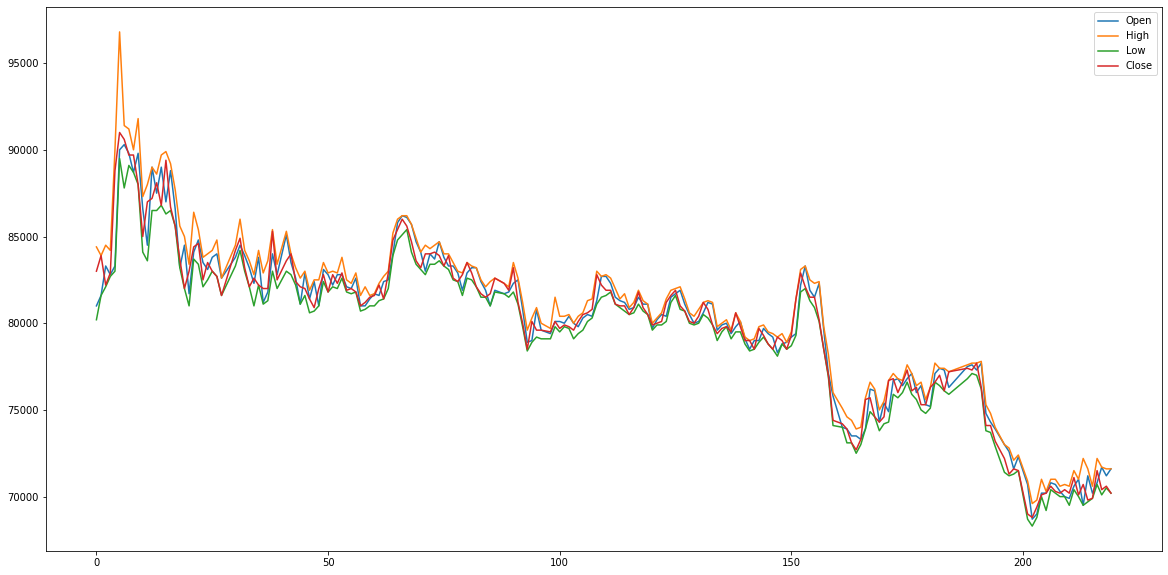

In [33]:
plt.figure(figsize=(20, 10))
merged_df['Open'].plot(label='Open')
merged_df['High'].plot(label='High')
merged_df['Low'].plot(label='Low')
merged_df['Close'].plot(label='Close')
plt.legend()
plt.show()

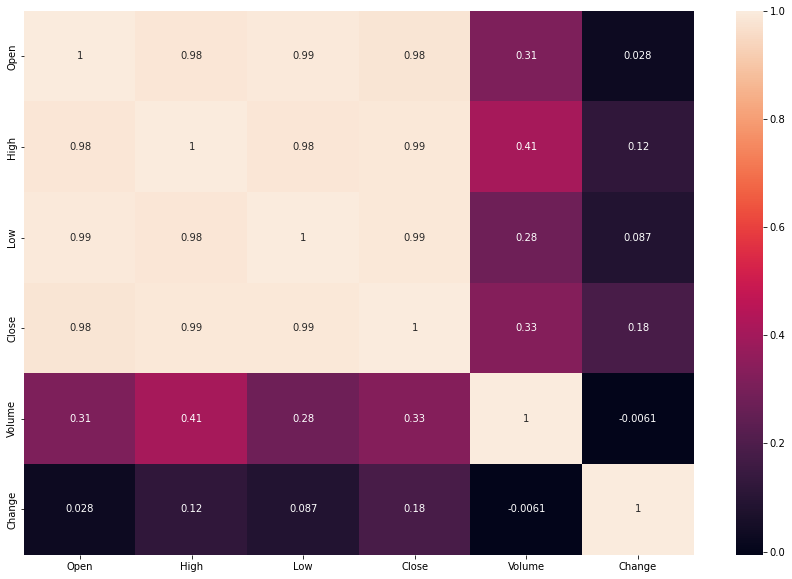

In [34]:
# 상관관계 확인
plt.figure(figsize=(15, 10))
sns.heatmap(merged_df.drop(['Date'], axis=1).corr(), annot=True)

# 평가 방식
* 지표: NMAE * 100
* public score: 11월 1일 ~ 11월 5일 주식 종료 예측값
* private score: 11월 29일 ~ 12월 3일 주식 종료 예측값

In [10]:
# 11월 1일 ~ 11월 5일까지만 지표 측정 가능
def nmae(true_df, pred_df):
  true_df = true_df.drop(['Day'], axis=1)
  pred_df = pred_df.drop(['Day'], axis=1)
  scores = []

  for code in pred_df.columns:
    true = true_df.loc[:, code].to_numpy()
    pred = pred_df.loc[:, code].to_numpy()

    score = np.mean((np.abs(true - pred)) / true)
    scores.append(score)

  return scores

# 모델 선택
* 기본 회귀 모델
* 부스팅 회귀 모델
* 딥러닝
* 통계 모델

In [100]:
!pip install statsmodels==0.12.2

     |████████████████████████████████| 9.5 MB 4.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [11]:
# Regression
from sklearn.linear_model import LinearRegression

# bagging
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# boosting
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# deep learning
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import LSTM, SimpleRNN, GRU

# Statistics
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# ARIMA
* AR(p), MA(q), 차분(d)
* 370개(종목) 모델에 대해 그래프를 살펴볼 수 없기 때문에 최적의 차수를 정하는데 AIC를 기준으로 함
* ACF, PACF 그래프 상으로 0에 빨리 수렴을 해야 정상성을 만족하는 것 -> 몇 lag 이후로 0에 급격히 수렴하는지에 따라 해당 lag가 p와 q의 후보가 되는 것
* https://leedakyeong.tistory.com/entry/Python-%EB%82%A0%EC%94%A8-%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%8D%B0%EC%9D%B4%ED%84%B0Kaggle%EB%A1%9C-ARIMA-%EC%A0%81%EC%9A%A9%ED%95%98%EA%B8%B0

## 샘플 데이터로 ARIMA 그래프 그려보기

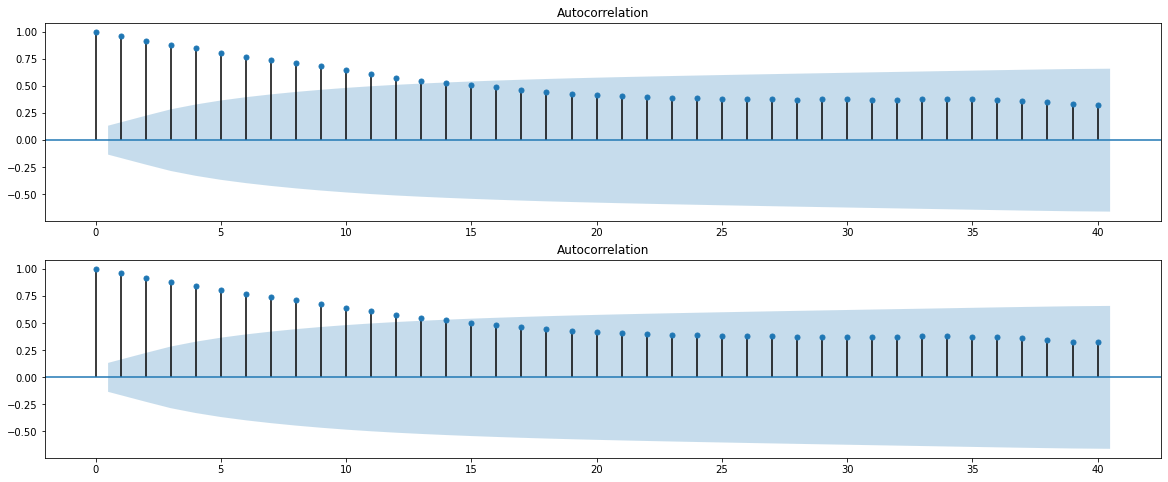

In [167]:
# ACF 그래프 / PACF 그래프 -> 0에 가까워지는 시점을 찾아야 함
import statsmodels.api as sm
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(arima_set['Close'], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_acf(arima_set['Close'], lags=40, ax=ax2)

In [168]:
# ADF 검정(aUGMENTED Dickey-Fuller test)
# H0: 정상성을 만족하지 않음 <-> H1: 정상성 만족
result = adfuller(arima_set['Close'])
print('ADF Statstic: %f' % result[0])
print('p-value: %f' % result[1]) # p-value > 0.05: 데이터가 정상성을 만족하지 못함
print('Critical Values: ')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statstic: -0.221678
p-value: 0.935888
Critical Values: 
	1%: -3.463
	5%: -2.876
	10%: -2.574


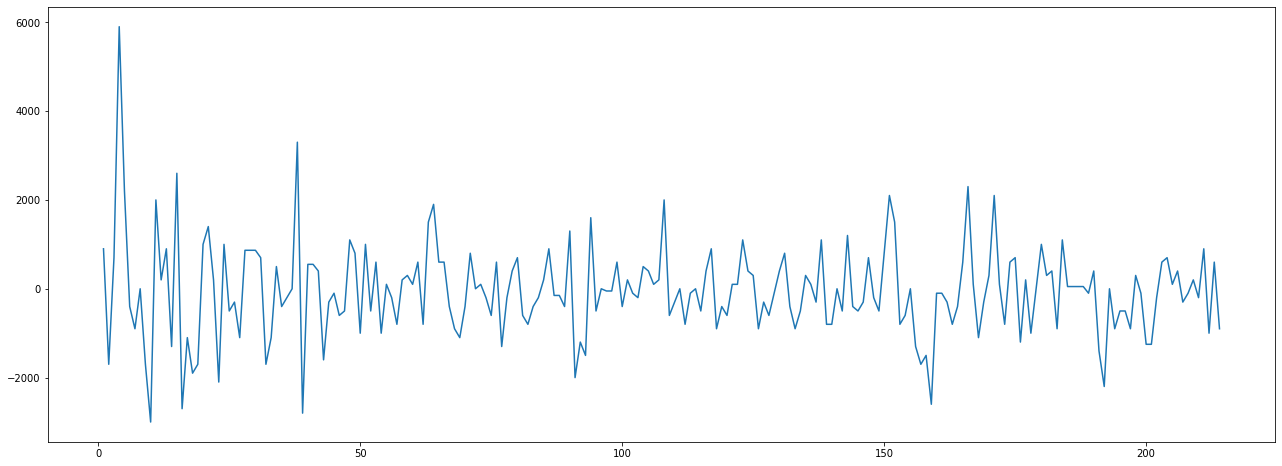

In [177]:
# 정상성 해결을 위해 1차 차분한 버전 -> 그래프 상으로 봐도 별다른 패턴이 보이지 않음(이게 정상)
close_diff = arima_set - arima_set.shift()
plt.figure(figsize=(22, 8))
plt.plot(close_diff['Close'])

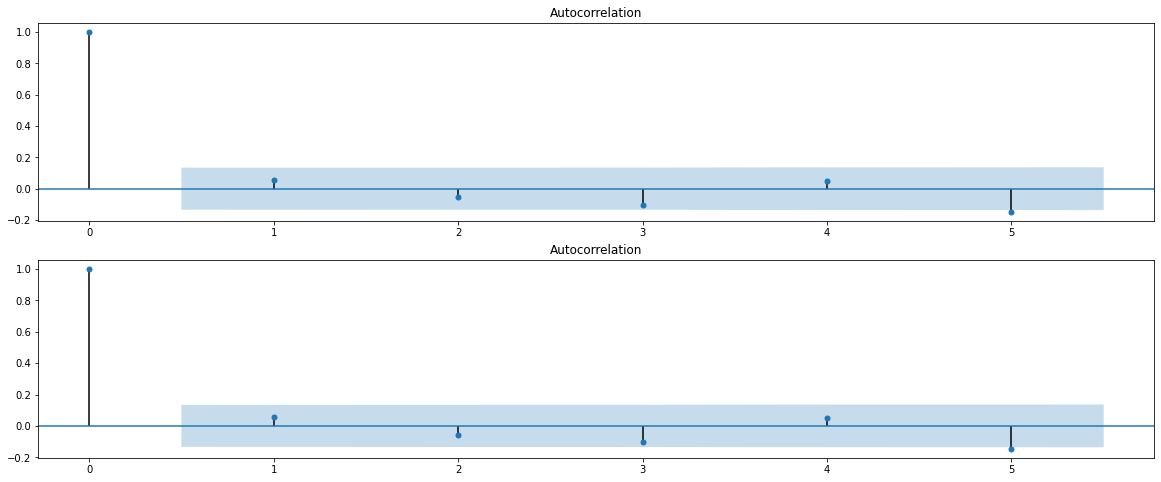

In [178]:
# ACF 그래프 / PACF 그래프
import statsmodels.api as sm
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(close_diff['Close'][1:], lags=5, ax=ax1) # 1차 차분했으므로 index는 1부터 시작
ax2 = fig.add_subplot(212)
fig = plot_acf(close_diff['Close'][1:], lags=5, ax=ax2)

In [179]:
# AIC 기준으로 최적의 p, q, d 찾는 함수
def my_auto_arima(data, order, sort='AIC'):
  order_list = []
  aic_list = []
  bic_lsit = []
  for p in range(order[0]):
    for d in range(order[1]):
      for q in range(order[2]):
        model = ARIMA(data, order=(p, d, q))
        
        try:
          model_fit = model.fit()
          c_order = f'p{p} d{d} q{q}'
          aic = model_fit.aic
          bic = model_fit.bic
          order_list.append(c_order)
          aic_list.append(aic)
          bic_list.append(bic)
        except:
          pass

  result_df = pd.DataFrame(list(zip(order_list, aic_list)), columns=['order', 'AIC'])
  result_df.sort_values(sort, inplace=True)
  return result_df

In [190]:
grid_df = my_auto_arima(arima_set['Close'], [3, 3, 3])
grid_df

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have

,order,AIC
26,p2 d2 q2,3574.579229
7,p0 d2 q1,3579.570166
8,p0 d2 q2,3580.818867
16,p1 d2 q1,3580.893627
17,p1 d2 q2,3581.867181
25,p2 d2 q1,3582.177456
22,p2 d1 q1,3584.116927
14,p1 d1 q2,3584.224921
3,p0 d1 q0,3588.629239
4,p0 d1 q1,3589.938082


In [200]:
# AR 모델 적용
try:
  ARIMA_MODEL = ARIMA(arima_set['Close'], order=(2, 2, 2)) # p, d, q
  ARIMA_MODEL_FIT = ARIMA_MODEL.fit(trend='nc', full_output=True, disp=True) # trend='nc': 상수가 없는 모형(non-constant) / disp=True: 수렴 정보가 출력
  print('수렴')
# 수렴하지 않을 경우 p d q 를 1, 1, 0으로 사용
except:
  ARIMA_MODEL = ARIMA(arima_set['Close'], order = (1, 1, 0))
  ARIMA_MODEL_FIT = ARIMA_MODEL.fit(trend='nc', full_output=True, disp=True)
  print('수렴하지 못함')

# ARIMA 예측
pred_start = 2
pred_end = len(merged_df) - 2
# train_prediction = ARIMA_MODEL_FIT.predict(start=pred_start, end=pred_end, typ='levels')
forecast = ARIMA_MODEL_FIT.forecast(steps=5)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


수렴


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [201]:
print(ARIMA_MODEL_FIT.summary()) # p-value로 봐서는 유의미하지 않은 결과임...

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  213
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -1786.649
Method:                       css-mle   S.D. of innovations           1050.290
Date:                Mon, 22 Nov 2021   AIC                           3583.297
Time:                        08:35:25   BIC                           3600.104
Sample:                             2   HQIC                          3590.089
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
ar.L1.D2.Close    -0.6310      0.350     -1.804      0.071      -1.317       0.055
ar.L2.D2.Close     0.0635      0.069      0.914      0.361      -0.073       0.200
ma.L1.D2.Close    -0.3109      0.344

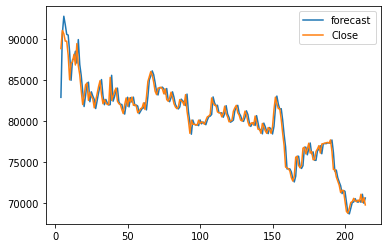

<Figure size 1440x720 with 0 Axes>

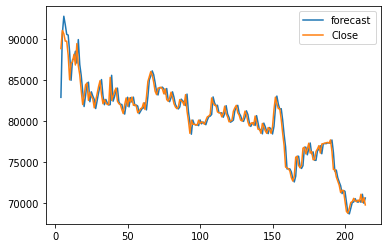

In [202]:
# 왜 그래프가 2개나 생기는지 모르겠음
ARIMA_MODEL_FIT.plot_predict()

In [22]:
# 전체 데이터셋 예측값 계산해서 DataFrame으로 저장하는 함수
def arima_predict():
  arima_forecast = pd.DataFrame()
  i = 0
  for code in tqdm(stock_list['종목코드'].values):
    data = fdr.DataReader(code, start=start_date, end=end_date)[['Close']].reset_index()
    data = pd.merge(Business_days, data, how='outer')
    data['Close'] = data['Close'].interpolate()

    data = data.iloc[:-1]
    # AR 모델 적용
    try:
      ARIMA_MODEL = ARIMA(data['Close'], order=(2, 2, 2)) # p, d, q
      ARIMA_MODEL_FIT = ARIMA_MODEL.fit(trend='nc', full_output=True, disp=True) # trend='nc': 상수가 없는 모형(non-constant) / disp=True: 수렴 정보가 출력
      print('수렴')
    # 수렴하지 않을 경우 p, d, q 를 1, 1, 0으로 사용
    except:
      ARIMA_MODEL = ARIMA(data['Close'], order = (1, 1, 0))
      ARIMA_MODEL_FIT = ARIMA_MODEL.fit(trend='nc', full_output=True, disp=True)
      print('수렴하지 못함')

    # ARIMA 예측
    pred_start = 2
    pred_end = len(data) - 2
    # train_prediction = ARIMA_MODEL_FIT.predict(start=pred_start, end=pred_end, typ='levels')
    forecast = ARIMA_MODEL_FIT.forecast(steps=5)
    tmp = pd.DataFrame(forecast[0].tolist(), columns=[code])

    arima_forecast = pd.concat([arima_forecast, tmp], axis=1)
    print(f'{i}번째 코드 예측값 추가 완료')
    i += 1
  return arima_forecast

In [23]:
arima_pred = arima_predict()
arima_pred

  0%|          | 1/370 [00:02<16:33,  2.69s/it]

수렴
0번째 코드 예측값 추가 완료


  1%|          | 2/370 [00:04<13:22,  2.18s/it]

수렴
1번째 코드 예측값 추가 완료


  1%|          | 3/370 [00:06<11:24,  1.86s/it]

수렴하지 못함
2번째 코드 예측값 추가 완료


  1%|          | 4/370 [00:07<10:21,  1.70s/it]

수렴
3번째 코드 예측값 추가 완료


  1%|▏         | 5/370 [00:08<09:00,  1.48s/it]

수렴
4번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
  2%|▏         | 6/370 [00:10<09:08,  1.51s/it]

수렴
5번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
  2%|▏         | 7/370 [00:11<09:34,  1.58s/it]

수렴
6번째 코드 예측값 추가 완료


  2%|▏         | 8/370 [00:13<09:24,  1.56s/it]

수렴
7번째 코드 예측값 추가 완료


  2%|▏         | 9/370 [00:14<09:10,  1.53s/it]

수렴
8번째 코드 예측값 추가 완료


  3%|▎         | 10/370 [00:16<09:17,  1.55s/it]

수렴
9번째 코드 예측값 추가 완료


  3%|▎         | 11/370 [00:18<09:38,  1.61s/it]

수렴
10번째 코드 예측값 추가 완료


  3%|▎         | 12/370 [00:19<09:40,  1.62s/it]

수렴
11번째 코드 예측값 추가 완료


  4%|▎         | 13/370 [00:21<09:16,  1.56s/it]

수렴
12번째 코드 예측값 추가 완료


  4%|▍         | 14/370 [00:22<08:57,  1.51s/it]

수렴
13번째 코드 예측값 추가 완료


  4%|▍         | 15/370 [00:23<08:30,  1.44s/it]

수렴하지 못함
14번째 코드 예측값 추가 완료


  4%|▍         | 16/370 [00:25<08:30,  1.44s/it]

수렴하지 못함
15번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
  5%|▍         | 17/370 [00:26<08:33,  1.45s/it]

수렴
16번째 코드 예측값 추가 완료


  5%|▍         | 18/370 [00:28<08:50,  1.51s/it]

수렴
17번째 코드 예측값 추가 완료


  5%|▌         | 19/370 [00:30<08:55,  1.53s/it]

수렴
18번째 코드 예측값 추가 완료


  5%|▌         | 20/370 [00:31<09:00,  1.54s/it]

수렴
19번째 코드 예측값 추가 완료


  6%|▌         | 21/370 [00:32<08:26,  1.45s/it]

수렴
20번째 코드 예측값 추가 완료


  6%|▌         | 22/370 [00:34<08:26,  1.46s/it]

수렴
21번째 코드 예측값 추가 완료


  6%|▌         | 23/370 [00:36<09:00,  1.56s/it]

수렴
22번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
  6%|▋         | 24/370 [00:37<08:44,  1.52s/it]

수렴
23번째 코드 예측값 추가 완료


  7%|▋         | 25/370 [00:39<08:41,  1.51s/it]

수렴
24번째 코드 예측값 추가 완료


  7%|▋         | 26/370 [00:40<08:12,  1.43s/it]

수렴
25번째 코드 예측값 추가 완료


  7%|▋         | 27/370 [00:42<08:52,  1.55s/it]

수렴
26번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
  8%|▊         | 28/370 [00:43<08:34,  1.51s/it]

수렴
27번째 코드 예측값 추가 완료


  8%|▊         | 29/370 [00:44<08:31,  1.50s/it]

수렴
28번째 코드 예측값 추가 완료


  8%|▊         | 30/370 [00:46<07:52,  1.39s/it]

수렴
29번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
  8%|▊         | 31/370 [00:47<07:58,  1.41s/it]

수렴
30번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
  9%|▊         | 32/370 [00:48<07:13,  1.28s/it]

수렴
31번째 코드 예측값 추가 완료


  9%|▉         | 33/370 [00:50<07:46,  1.38s/it]

수렴
32번째 코드 예측값 추가 완료


  9%|▉         | 34/370 [00:51<07:33,  1.35s/it]

수렴하지 못함
33번째 코드 예측값 추가 완료


  9%|▉         | 35/370 [00:52<07:24,  1.33s/it]

수렴하지 못함
34번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 10%|▉         | 36/370 [00:54<07:35,  1.36s/it]

수렴
35번째 코드 예측값 추가 완료


 10%|█         | 37/370 [00:55<07:42,  1.39s/it]

수렴하지 못함
36번째 코드 예측값 추가 완료


 10%|█         | 38/370 [00:56<07:26,  1.34s/it]

수렴하지 못함
37번째 코드 예측값 추가 완료


 11%|█         | 39/370 [00:58<07:19,  1.33s/it]

수렴하지 못함
38번째 코드 예측값 추가 완료


 11%|█         | 40/370 [00:59<06:52,  1.25s/it]

수렴
39번째 코드 예측값 추가 완료


 11%|█         | 41/370 [01:00<07:18,  1.33s/it]

수렴
40번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 11%|█▏        | 42/370 [01:02<07:42,  1.41s/it]

수렴
41번째 코드 예측값 추가 완료


 12%|█▏        | 43/370 [01:03<07:27,  1.37s/it]

수렴하지 못함
42번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 12%|█▏        | 44/370 [01:05<07:40,  1.41s/it]

수렴
43번째 코드 예측값 추가 완료


 12%|█▏        | 45/370 [01:06<07:09,  1.32s/it]

수렴
44번째 코드 예측값 추가 완료


 12%|█▏        | 46/370 [01:07<07:25,  1.37s/it]

수렴
45번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 13%|█▎        | 47/370 [01:09<07:48,  1.45s/it]

수렴
46번째 코드 예측값 추가 완료


 13%|█▎        | 48/370 [01:10<07:25,  1.38s/it]

수렴하지 못함
47번째 코드 예측값 추가 완료


 13%|█▎        | 49/370 [01:12<07:45,  1.45s/it]

수렴
48번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 14%|█▎        | 50/370 [01:13<07:36,  1.43s/it]

수렴
49번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 14%|█▍        | 51/370 [01:15<08:02,  1.51s/it]

수렴
50번째 코드 예측값 추가 완료


 14%|█▍        | 52/370 [01:16<07:46,  1.47s/it]

수렴
51번째 코드 예측값 추가 완료


 14%|█▍        | 53/370 [01:18<08:18,  1.57s/it]

수렴
52번째 코드 예측값 추가 완료


 15%|█▍        | 54/370 [01:19<08:08,  1.55s/it]

수렴하지 못함
53번째 코드 예측값 추가 완료


 15%|█▍        | 55/370 [01:21<07:36,  1.45s/it]

수렴
54번째 코드 예측값 추가 완료


 15%|█▌        | 56/370 [01:22<08:00,  1.53s/it]

수렴
55번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 15%|█▌        | 57/370 [01:24<08:01,  1.54s/it]

수렴
56번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 16%|█▌        | 58/370 [01:25<07:51,  1.51s/it]

수렴
57번째 코드 예측값 추가 완료


 16%|█▌        | 59/370 [01:26<06:53,  1.33s/it]

수렴하지 못함
58번째 코드 예측값 추가 완료


 16%|█▌        | 60/370 [01:28<06:57,  1.35s/it]

수렴하지 못함
59번째 코드 예측값 추가 완료


 16%|█▋        | 61/370 [01:30<07:50,  1.52s/it]

수렴
60번째 코드 예측값 추가 완료


 17%|█▋        | 62/370 [01:31<07:38,  1.49s/it]

수렴
61번째 코드 예측값 추가 완료


 17%|█▋        | 63/370 [01:33<07:37,  1.49s/it]

수렴
62번째 코드 예측값 추가 완료


 17%|█▋        | 64/370 [01:34<07:32,  1.48s/it]

수렴
63번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 18%|█▊        | 65/370 [01:36<07:45,  1.52s/it]

수렴
64번째 코드 예측값 추가 완료


 18%|█▊        | 66/370 [01:37<06:48,  1.34s/it]

수렴하지 못함
65번째 코드 예측값 추가 완료


 18%|█▊        | 67/370 [01:38<06:38,  1.32s/it]

수렴
66번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 18%|█▊        | 68/370 [01:39<06:49,  1.36s/it]

수렴
67번째 코드 예측값 추가 완료


 19%|█▊        | 69/370 [01:41<06:57,  1.39s/it]

수렴하지 못함
68번째 코드 예측값 추가 완료


 19%|█▉        | 70/370 [01:42<06:47,  1.36s/it]

수렴하지 못함
69번째 코드 예측값 추가 완료


 19%|█▉        | 71/370 [01:43<06:56,  1.39s/it]

수렴
70번째 코드 예측값 추가 완료


 19%|█▉        | 72/370 [01:45<07:04,  1.43s/it]

수렴
71번째 코드 예측값 추가 완료


 20%|█▉        | 73/370 [01:47<07:26,  1.50s/it]

수렴
72번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 20%|██        | 74/370 [01:48<07:20,  1.49s/it]

수렴
73번째 코드 예측값 추가 완료


 20%|██        | 75/370 [01:49<07:11,  1.46s/it]

수렴
74번째 코드 예측값 추가 완료


 21%|██        | 76/370 [01:51<07:15,  1.48s/it]

수렴
75번째 코드 예측값 추가 완료


 21%|██        | 77/370 [01:53<07:29,  1.53s/it]

수렴
76번째 코드 예측값 추가 완료


 21%|██        | 78/370 [01:54<07:52,  1.62s/it]

수렴
77번째 코드 예측값 추가 완료


 21%|██▏       | 79/370 [01:56<07:33,  1.56s/it]

수렴
78번째 코드 예측값 추가 완료


 22%|██▏       | 80/370 [01:57<06:54,  1.43s/it]

수렴하지 못함
79번째 코드 예측값 추가 완료


 22%|██▏       | 81/370 [01:58<06:38,  1.38s/it]

수렴하지 못함
80번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 22%|██▏       | 82/370 [02:00<06:34,  1.37s/it]

수렴
81번째 코드 예측값 추가 완료


 22%|██▏       | 83/370 [02:01<06:07,  1.28s/it]

수렴하지 못함
82번째 코드 예측값 추가 완료


 23%|██▎       | 84/370 [02:02<06:16,  1.32s/it]

수렴
83번째 코드 예측값 추가 완료


 23%|██▎       | 85/370 [02:04<06:30,  1.37s/it]

수렴하지 못함
84번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 23%|██▎       | 86/370 [02:05<06:52,  1.45s/it]

수렴
85번째 코드 예측값 추가 완료


 24%|██▎       | 87/370 [02:07<06:51,  1.45s/it]

수렴
86번째 코드 예측값 추가 완료


 24%|██▍       | 88/370 [02:08<06:19,  1.34s/it]

수렴
87번째 코드 예측값 추가 완료


 24%|██▍       | 89/370 [02:09<06:24,  1.37s/it]

수렴
88번째 코드 예측값 추가 완료


 24%|██▍       | 90/370 [02:11<06:27,  1.39s/it]

수렴
89번째 코드 예측값 추가 완료


 25%|██▍       | 91/370 [02:12<06:32,  1.41s/it]

수렴
90번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 25%|██▍       | 92/370 [02:14<06:51,  1.48s/it]

수렴
91번째 코드 예측값 추가 완료


 25%|██▌       | 93/370 [02:15<06:50,  1.48s/it]

수렴
92번째 코드 예측값 추가 완료


 25%|██▌       | 94/370 [02:17<06:47,  1.48s/it]

수렴
93번째 코드 예측값 추가 완료


 26%|██▌       | 95/370 [02:18<06:12,  1.36s/it]

수렴하지 못함
94번째 코드 예측값 추가 완료


 26%|██▌       | 96/370 [02:19<06:15,  1.37s/it]

수렴
95번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 26%|██▌       | 97/370 [02:20<05:40,  1.25s/it]

수렴
96번째 코드 예측값 추가 완료


 26%|██▋       | 98/370 [02:21<05:47,  1.28s/it]

수렴
97번째 코드 예측값 추가 완료


 27%|██▋       | 99/370 [02:22<05:22,  1.19s/it]

수렴
98번째 코드 예측값 추가 완료


 27%|██▋       | 100/370 [02:24<05:25,  1.21s/it]

수렴하지 못함
99번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 27%|██▋       | 101/370 [02:25<05:51,  1.31s/it]

수렴
100번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 28%|██▊       | 102/370 [02:27<06:08,  1.37s/it]

수렴
101번째 코드 예측값 추가 완료


 28%|██▊       | 103/370 [02:28<06:17,  1.41s/it]

수렴
102번째 코드 예측값 추가 완료


 28%|██▊       | 104/370 [02:30<06:03,  1.37s/it]

수렴하지 못함
103번째 코드 예측값 추가 완료


 28%|██▊       | 105/370 [02:31<06:23,  1.45s/it]

수렴
104번째 코드 예측값 추가 완료


 29%|██▊       | 106/370 [02:32<05:53,  1.34s/it]

수렴하지 못함
105번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 29%|██▉       | 107/370 [02:34<06:13,  1.42s/it]

수렴
106번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 29%|██▉       | 108/370 [02:35<06:16,  1.44s/it]

수렴
107번째 코드 예측값 추가 완료


 29%|██▉       | 109/370 [02:37<06:18,  1.45s/it]

수렴
108번째 코드 예측값 추가 완료


 30%|██▉       | 110/370 [02:38<06:28,  1.49s/it]

수렴
109번째 코드 예측값 추가 완료


 30%|███       | 111/370 [02:40<06:00,  1.39s/it]

수렴
110번째 코드 예측값 추가 완료


 30%|███       | 112/370 [02:41<06:00,  1.40s/it]

수렴
111번째 코드 예측값 추가 완료


 31%|███       | 113/370 [02:43<06:09,  1.44s/it]

수렴
112번째 코드 예측값 추가 완료


 31%|███       | 114/370 [02:44<05:50,  1.37s/it]

수렴
113번째 코드 예측값 추가 완료


 31%|███       | 115/370 [02:45<05:54,  1.39s/it]

수렴
114번째 코드 예측값 추가 완료


 31%|███▏      | 116/370 [02:47<06:05,  1.44s/it]

수렴하지 못함
115번째 코드 예측값 추가 완료


 32%|███▏      | 117/370 [02:48<05:52,  1.39s/it]

수렴
116번째 코드 예측값 추가 완료


 32%|███▏      | 118/370 [02:49<05:55,  1.41s/it]

수렴
117번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 32%|███▏      | 119/370 [02:51<05:54,  1.41s/it]

수렴
118번째 코드 예측값 추가 완료


 32%|███▏      | 120/370 [02:52<05:53,  1.42s/it]

수렴
119번째 코드 예측값 추가 완료


 33%|███▎      | 121/370 [02:54<05:40,  1.37s/it]

수렴
120번째 코드 예측값 추가 완료


 33%|███▎      | 122/370 [02:55<05:49,  1.41s/it]

수렴
121번째 코드 예측값 추가 완료


 33%|███▎      | 123/370 [02:57<05:59,  1.46s/it]

수렴
122번째 코드 예측값 추가 완료


 34%|███▎      | 124/370 [02:58<05:58,  1.46s/it]

수렴
123번째 코드 예측값 추가 완료


 34%|███▍      | 125/370 [02:59<05:50,  1.43s/it]

수렴
124번째 코드 예측값 추가 완료


 34%|███▍      | 126/370 [03:01<05:42,  1.41s/it]

수렴
125번째 코드 예측값 추가 완료


 34%|███▍      | 127/370 [03:02<05:34,  1.38s/it]

수렴
126번째 코드 예측값 추가 완료


 35%|███▍      | 128/370 [03:04<05:47,  1.44s/it]

수렴
127번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 35%|███▍      | 129/370 [03:05<06:03,  1.51s/it]

수렴
128번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 35%|███▌      | 130/370 [03:07<06:04,  1.52s/it]

수렴
129번째 코드 예측값 추가 완료


 35%|███▌      | 131/370 [03:08<05:57,  1.50s/it]

수렴
130번째 코드 예측값 추가 완료


 36%|███▌      | 132/370 [03:10<05:30,  1.39s/it]

수렴
131번째 코드 예측값 추가 완료


 36%|███▌      | 133/370 [03:11<05:17,  1.34s/it]

수렴
132번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 36%|███▌      | 134/370 [03:12<05:27,  1.39s/it]

수렴
133번째 코드 예측값 추가 완료


 36%|███▋      | 135/370 [03:14<05:23,  1.38s/it]

수렴
134번째 코드 예측값 추가 완료


 37%|███▋      | 136/370 [03:15<05:32,  1.42s/it]

수렴
135번째 코드 예측값 추가 완료


 37%|███▋      | 137/370 [03:16<05:21,  1.38s/it]

수렴
136번째 코드 예측값 추가 완료


 37%|███▋      | 138/370 [03:18<05:43,  1.48s/it]

수렴
137번째 코드 예측값 추가 완료


 38%|███▊      | 139/370 [03:19<05:00,  1.30s/it]

수렴하지 못함
138번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 38%|███▊      | 140/370 [03:20<04:59,  1.30s/it]

수렴하지 못함
139번째 코드 예측값 추가 완료


 38%|███▊      | 141/370 [03:22<05:09,  1.35s/it]

수렴
140번째 코드 예측값 추가 완료


 38%|███▊      | 142/370 [03:23<05:20,  1.41s/it]

수렴
141번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 39%|███▊      | 143/370 [03:25<05:34,  1.48s/it]

수렴
142번째 코드 예측값 추가 완료


 39%|███▉      | 144/370 [03:26<05:32,  1.47s/it]

수렴
143번째 코드 예측값 추가 완료


 39%|███▉      | 145/370 [03:28<05:42,  1.52s/it]

수렴
144번째 코드 예측값 추가 완료


 39%|███▉      | 146/370 [03:30<05:43,  1.53s/it]

수렴
145번째 코드 예측값 추가 완료


 40%|███▉      | 147/370 [03:31<05:37,  1.51s/it]

수렴
146번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 40%|████      | 148/370 [03:33<05:31,  1.49s/it]

수렴
147번째 코드 예측값 추가 완료


 40%|████      | 149/370 [03:34<05:33,  1.51s/it]

수렴
148번째 코드 예측값 추가 완료


 41%|████      | 150/370 [03:35<05:17,  1.44s/it]

수렴
149번째 코드 예측값 추가 완료


 41%|████      | 151/370 [03:36<04:52,  1.34s/it]

수렴
150번째 코드 예측값 추가 완료


 41%|████      | 152/370 [03:38<04:46,  1.31s/it]

수렴
151번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 41%|████▏     | 153/370 [03:39<05:06,  1.41s/it]

수렴
152번째 코드 예측값 추가 완료


 42%|████▏     | 154/370 [03:41<05:15,  1.46s/it]

수렴
153번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 42%|████▏     | 155/370 [03:42<05:14,  1.46s/it]

수렴
154번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 42%|████▏     | 156/370 [03:44<05:19,  1.49s/it]

수렴
155번째 코드 예측값 추가 완료


 42%|████▏     | 157/370 [03:45<05:19,  1.50s/it]

수렴
156번째 코드 예측값 추가 완료


 43%|████▎     | 158/370 [03:46<04:43,  1.34s/it]

수렴
157번째 코드 예측값 추가 완료


 43%|████▎     | 159/370 [03:47<04:10,  1.19s/it]

수렴하지 못함
158번째 코드 예측값 추가 완료


 43%|████▎     | 160/370 [03:49<04:30,  1.29s/it]

수렴
159번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 44%|████▎     | 161/370 [03:50<04:38,  1.33s/it]

수렴
160번째 코드 예측값 추가 완료


 44%|████▍     | 162/370 [03:52<04:46,  1.38s/it]

수렴
161번째 코드 예측값 추가 완료


 44%|████▍     | 163/370 [03:53<04:41,  1.36s/it]

수렴
162번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 44%|████▍     | 164/370 [03:54<04:43,  1.38s/it]

수렴
163번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 45%|████▍     | 165/370 [03:56<04:53,  1.43s/it]

수렴
164번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 45%|████▍     | 166/370 [03:58<05:13,  1.54s/it]

수렴
165번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 45%|████▌     | 167/370 [03:59<05:08,  1.52s/it]

수렴
166번째 코드 예측값 추가 완료


 45%|████▌     | 168/370 [04:01<04:56,  1.47s/it]

수렴하지 못함
167번째 코드 예측값 추가 완료


 46%|████▌     | 169/370 [04:01<04:12,  1.26s/it]

수렴하지 못함
168번째 코드 예측값 추가 완료


 46%|████▌     | 170/370 [04:03<04:19,  1.30s/it]

수렴
169번째 코드 예측값 추가 완료


 46%|████▌     | 171/370 [04:04<04:14,  1.28s/it]

수렴
170번째 코드 예측값 추가 완료


 46%|████▋     | 172/370 [04:05<04:01,  1.22s/it]

수렴하지 못함
171번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 47%|████▋     | 173/370 [04:06<04:05,  1.25s/it]

수렴
172번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 47%|████▋     | 174/370 [04:08<04:17,  1.31s/it]

수렴
173번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 47%|████▋     | 175/370 [04:09<04:23,  1.35s/it]

수렴
174번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 48%|████▊     | 176/370 [04:11<04:28,  1.38s/it]

수렴
175번째 코드 예측값 추가 완료


 48%|████▊     | 177/370 [04:11<03:50,  1.19s/it]

수렴하지 못함
176번째 코드 예측값 추가 완료


 48%|████▊     | 178/370 [04:13<03:54,  1.22s/it]

수렴
177번째 코드 예측값 추가 완료


 48%|████▊     | 179/370 [04:14<03:35,  1.13s/it]

수렴하지 못함
178번째 코드 예측값 추가 완료


 49%|████▊     | 180/370 [04:15<03:43,  1.18s/it]

수렴하지 못함
179번째 코드 예측값 추가 완료


 49%|████▉     | 181/370 [04:16<03:49,  1.21s/it]

수렴
180번째 코드 예측값 추가 완료


 49%|████▉     | 182/370 [04:18<03:51,  1.23s/it]

수렴
181번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 49%|████▉     | 183/370 [04:19<04:15,  1.37s/it]

수렴
182번째 코드 예측값 추가 완료


 50%|████▉     | 184/370 [04:21<04:24,  1.42s/it]

수렴
183번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 50%|█████     | 185/370 [04:22<04:24,  1.43s/it]

수렴
184번째 코드 예측값 추가 완료


 50%|█████     | 186/370 [04:23<04:06,  1.34s/it]

수렴
185번째 코드 예측값 추가 완료


 51%|█████     | 187/370 [04:24<03:39,  1.20s/it]

수렴
186번째 코드 예측값 추가 완료


 51%|█████     | 188/370 [04:25<03:21,  1.11s/it]

수렴하지 못함
187번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 51%|█████     | 189/370 [04:27<03:40,  1.22s/it]

수렴
188번째 코드 예측값 추가 완료


 51%|█████▏    | 190/370 [04:28<03:32,  1.18s/it]

수렴
189번째 코드 예측값 추가 완료


 52%|█████▏    | 191/370 [04:29<03:56,  1.32s/it]

수렴
190번째 코드 예측값 추가 완료


 52%|█████▏    | 192/370 [04:31<04:05,  1.38s/it]

수렴
191번째 코드 예측값 추가 완료


 52%|█████▏    | 193/370 [04:32<03:59,  1.35s/it]

수렴
192번째 코드 예측값 추가 완료


 52%|█████▏    | 194/370 [04:34<04:10,  1.42s/it]

수렴
193번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 53%|█████▎    | 195/370 [04:35<04:17,  1.47s/it]

수렴
194번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 53%|█████▎    | 196/370 [04:37<04:12,  1.45s/it]

수렴
195번째 코드 예측값 추가 완료


 53%|█████▎    | 197/370 [04:38<04:01,  1.40s/it]

수렴
196번째 코드 예측값 추가 완료


 54%|█████▎    | 198/370 [04:39<03:46,  1.32s/it]

수렴
197번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 54%|█████▍    | 199/370 [04:41<04:03,  1.42s/it]

수렴
198번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 54%|█████▍    | 200/370 [04:42<03:35,  1.27s/it]

수렴
199번째 코드 예측값 추가 완료


 54%|█████▍    | 201/370 [04:43<03:30,  1.25s/it]

수렴
200번째 코드 예측값 추가 완료


 55%|█████▍    | 202/370 [04:44<03:41,  1.32s/it]

수렴
201번째 코드 예측값 추가 완료


 55%|█████▍    | 203/370 [04:45<03:28,  1.25s/it]

수렴
202번째 코드 예측값 추가 완료


 55%|█████▌    | 204/370 [04:47<03:46,  1.37s/it]

수렴
203번째 코드 예측값 추가 완료


 55%|█████▌    | 205/370 [04:48<03:45,  1.37s/it]

수렴
204번째 코드 예측값 추가 완료


 56%|█████▌    | 206/370 [04:50<03:50,  1.40s/it]

수렴
205번째 코드 예측값 추가 완료


 56%|█████▌    | 207/370 [04:51<03:40,  1.35s/it]

수렴
206번째 코드 예측값 추가 완료


 56%|█████▌    | 208/370 [04:53<03:51,  1.43s/it]

수렴
207번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 56%|█████▋    | 209/370 [04:54<03:49,  1.43s/it]

수렴
208번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 57%|█████▋    | 210/370 [04:56<03:58,  1.49s/it]

수렴
209번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 57%|█████▋    | 211/370 [04:57<03:44,  1.41s/it]

수렴
210번째 코드 예측값 추가 완료


 57%|█████▋    | 212/370 [04:59<03:42,  1.41s/it]

수렴
211번째 코드 예측값 추가 완료


 58%|█████▊    | 213/370 [05:00<03:50,  1.47s/it]

수렴
212번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 58%|█████▊    | 214/370 [05:02<03:56,  1.52s/it]

수렴
213번째 코드 예측값 추가 완료


 58%|█████▊    | 215/370 [05:03<03:50,  1.49s/it]

수렴
214번째 코드 예측값 추가 완료


 58%|█████▊    | 216/370 [05:05<03:48,  1.49s/it]

수렴
215번째 코드 예측값 추가 완료


 59%|█████▊    | 217/370 [05:06<03:55,  1.54s/it]

수렴
216번째 코드 예측값 추가 완료


 59%|█████▉    | 218/370 [05:08<03:41,  1.45s/it]

수렴하지 못함
217번째 코드 예측값 추가 완료


 59%|█████▉    | 219/370 [05:09<03:21,  1.34s/it]

수렴
218번째 코드 예측값 추가 완료


 59%|█████▉    | 220/370 [05:10<03:27,  1.38s/it]

수렴
219번째 코드 예측값 추가 완료


 60%|█████▉    | 221/370 [05:12<03:28,  1.40s/it]

수렴
220번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 60%|██████    | 222/370 [05:13<03:31,  1.43s/it]

수렴
221번째 코드 예측값 추가 완료


 60%|██████    | 223/370 [05:14<03:27,  1.41s/it]

수렴
222번째 코드 예측값 추가 완료


 61%|██████    | 224/370 [05:16<03:20,  1.37s/it]

수렴
223번째 코드 예측값 추가 완료


 61%|██████    | 225/370 [05:17<03:24,  1.41s/it]

수렴
224번째 코드 예측값 추가 완료


 61%|██████    | 226/370 [05:19<03:18,  1.38s/it]

수렴
225번째 코드 예측값 추가 완료


 61%|██████▏   | 227/370 [05:20<03:15,  1.37s/it]

수렴
226번째 코드 예측값 추가 완료


 62%|██████▏   | 228/370 [05:21<03:09,  1.34s/it]

수렴하지 못함
227번째 코드 예측값 추가 완료


 62%|██████▏   | 229/370 [05:22<03:04,  1.31s/it]

수렴
228번째 코드 예측값 추가 완료


 62%|██████▏   | 230/370 [05:24<03:03,  1.31s/it]

수렴
229번째 코드 예측값 추가 완료


 62%|██████▏   | 231/370 [05:24<02:38,  1.14s/it]

수렴하지 못함
230번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 63%|██████▎   | 232/370 [05:25<02:26,  1.06s/it]

수렴
231번째 코드 예측값 추가 완료


 63%|██████▎   | 233/370 [05:27<02:41,  1.18s/it]

수렴
232번째 코드 예측값 추가 완료


 63%|██████▎   | 234/370 [05:28<02:38,  1.16s/it]

수렴하지 못함
233번째 코드 예측값 추가 완료


 64%|██████▎   | 235/370 [05:29<02:49,  1.25s/it]

수렴하지 못함
234번째 코드 예측값 추가 완료


 64%|██████▍   | 236/370 [05:31<02:57,  1.32s/it]

수렴
235번째 코드 예측값 추가 완료


 64%|██████▍   | 237/370 [05:32<03:03,  1.38s/it]

수렴
236번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 64%|██████▍   | 238/370 [05:34<03:14,  1.47s/it]

수렴
237번째 코드 예측값 추가 완료


 65%|██████▍   | 239/370 [05:35<03:04,  1.41s/it]

수렴
238번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 65%|██████▍   | 240/370 [05:37<03:06,  1.44s/it]

수렴
239번째 코드 예측값 추가 완료


 65%|██████▌   | 241/370 [05:39<03:39,  1.70s/it]

수렴
240번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 65%|██████▌   | 242/370 [05:40<03:22,  1.58s/it]

수렴
241번째 코드 예측값 추가 완료


 66%|██████▌   | 243/370 [05:42<03:09,  1.49s/it]

수렴하지 못함
242번째 코드 예측값 추가 완료


 66%|██████▌   | 244/370 [05:43<02:54,  1.39s/it]

수렴
243번째 코드 예측값 추가 완료


 66%|██████▌   | 245/370 [05:44<02:56,  1.41s/it]

수렴
244번째 코드 예측값 추가 완료


 66%|██████▋   | 246/370 [05:45<02:43,  1.32s/it]

수렴
245번째 코드 예측값 추가 완료


 67%|██████▋   | 247/370 [05:46<02:32,  1.24s/it]

수렴하지 못함
246번째 코드 예측값 추가 완료


 67%|██████▋   | 248/370 [05:48<02:36,  1.28s/it]

수렴
247번째 코드 예측값 추가 완료


 67%|██████▋   | 249/370 [05:49<02:21,  1.17s/it]

수렴하지 못함
248번째 코드 예측값 추가 완료


 68%|██████▊   | 250/370 [05:50<02:25,  1.21s/it]

수렴
249번째 코드 예측값 추가 완료


 68%|██████▊   | 251/370 [05:51<02:28,  1.25s/it]

수렴
250번째 코드 예측값 추가 완료


 68%|██████▊   | 252/370 [05:53<02:29,  1.27s/it]

수렴
251번째 코드 예측값 추가 완료


 68%|██████▊   | 253/370 [05:54<02:38,  1.35s/it]

수렴
252번째 코드 예측값 추가 완료


 69%|██████▊   | 254/370 [05:55<02:30,  1.29s/it]

수렴
253번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 69%|██████▉   | 255/370 [05:57<02:32,  1.33s/it]

수렴
254번째 코드 예측값 추가 완료


 69%|██████▉   | 256/370 [05:58<02:29,  1.31s/it]

수렴
255번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 69%|██████▉   | 257/370 [06:00<02:33,  1.36s/it]

수렴
256번째 코드 예측값 추가 완료


 70%|██████▉   | 258/370 [06:01<02:32,  1.36s/it]

수렴
257번째 코드 예측값 추가 완료


 70%|███████   | 259/370 [06:02<02:28,  1.34s/it]

수렴
258번째 코드 예측값 추가 완료


 70%|███████   | 260/370 [06:03<02:23,  1.30s/it]

수렴
259번째 코드 예측값 추가 완료


 71%|███████   | 261/370 [06:05<02:25,  1.34s/it]

수렴
260번째 코드 예측값 추가 완료


 71%|███████   | 262/370 [06:06<02:24,  1.34s/it]

수렴
261번째 코드 예측값 추가 완료


 71%|███████   | 263/370 [06:07<02:21,  1.32s/it]

수렴하지 못함
262번째 코드 예측값 추가 완료


 71%|███████▏  | 264/370 [06:09<02:20,  1.32s/it]

수렴
263번째 코드 예측값 추가 완료


 72%|███████▏  | 265/370 [06:10<02:15,  1.29s/it]

수렴
264번째 코드 예측값 추가 완료


 72%|███████▏  | 266/370 [06:11<02:08,  1.24s/it]

수렴
265번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 72%|███████▏  | 267/370 [06:12<02:08,  1.25s/it]

수렴
266번째 코드 예측값 추가 완료


 72%|███████▏  | 268/370 [06:14<02:08,  1.26s/it]

수렴
267번째 코드 예측값 추가 완료


 73%|███████▎  | 269/370 [06:15<02:02,  1.22s/it]

수렴
268번째 코드 예측값 추가 완료


 73%|███████▎  | 270/370 [06:16<02:14,  1.35s/it]

수렴
269번째 코드 예측값 추가 완료


 73%|███████▎  | 271/370 [06:18<02:19,  1.41s/it]

수렴
270번째 코드 예측값 추가 완료


 74%|███████▎  | 272/370 [06:19<02:17,  1.40s/it]

수렴
271번째 코드 예측값 추가 완료


 74%|███████▍  | 273/370 [06:21<02:18,  1.42s/it]

수렴
272번째 코드 예측값 추가 완료


 74%|███████▍  | 274/370 [06:22<02:11,  1.37s/it]

수렴
273번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 74%|███████▍  | 275/370 [06:23<02:04,  1.31s/it]

수렴
274번째 코드 예측값 추가 완료


 75%|███████▍  | 276/370 [06:24<01:58,  1.26s/it]

수렴
275번째 코드 예측값 추가 완료


 75%|███████▍  | 277/370 [06:26<02:02,  1.32s/it]

수렴
276번째 코드 예측값 추가 완료


 75%|███████▌  | 278/370 [06:27<02:08,  1.40s/it]

수렴
277번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 75%|███████▌  | 279/370 [06:29<02:03,  1.35s/it]

수렴
278번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 76%|███████▌  | 280/370 [06:30<02:01,  1.35s/it]

수렴
279번째 코드 예측값 추가 완료


 76%|███████▌  | 281/370 [06:31<01:53,  1.27s/it]

수렴하지 못함
280번째 코드 예측값 추가 완료


 76%|███████▌  | 282/370 [06:33<01:59,  1.35s/it]

수렴
281번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 76%|███████▋  | 283/370 [06:34<02:00,  1.39s/it]

수렴
282번째 코드 예측값 추가 완료


 77%|███████▋  | 284/370 [06:35<01:51,  1.30s/it]

수렴
283번째 코드 예측값 추가 완료


 77%|███████▋  | 285/370 [06:37<01:54,  1.35s/it]

수렴
284번째 코드 예측값 추가 완료


 77%|███████▋  | 286/370 [06:38<01:51,  1.33s/it]

수렴
285번째 코드 예측값 추가 완료


 78%|███████▊  | 287/370 [06:39<01:51,  1.34s/it]

수렴
286번째 코드 예측값 추가 완료


 78%|███████▊  | 288/370 [06:40<01:39,  1.21s/it]

수렴하지 못함
287번째 코드 예측값 추가 완료


 78%|███████▊  | 289/370 [06:42<01:44,  1.29s/it]

수렴
288번째 코드 예측값 추가 완료


 78%|███████▊  | 290/370 [06:43<01:42,  1.28s/it]

수렴하지 못함
289번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 79%|███████▊  | 291/370 [06:45<01:54,  1.44s/it]

수렴
290번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 79%|███████▉  | 292/370 [06:46<01:48,  1.39s/it]

수렴
291번째 코드 예측값 추가 완료


 79%|███████▉  | 293/370 [06:47<01:44,  1.36s/it]

수렴
292번째 코드 예측값 추가 완료


 79%|███████▉  | 294/370 [06:49<01:46,  1.41s/it]

수렴
293번째 코드 예측값 추가 완료


 80%|███████▉  | 295/370 [06:50<01:33,  1.25s/it]

수렴하지 못함
294번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 80%|████████  | 296/370 [06:51<01:40,  1.36s/it]

수렴
295번째 코드 예측값 추가 완료


 80%|████████  | 297/370 [06:52<01:33,  1.27s/it]

수렴하지 못함
296번째 코드 예측값 추가 완료


 81%|████████  | 298/370 [06:54<01:40,  1.39s/it]

수렴
297번째 코드 예측값 추가 완료


 81%|████████  | 299/370 [06:55<01:28,  1.25s/it]

수렴하지 못함
298번째 코드 예측값 추가 완료


 81%|████████  | 300/370 [06:56<01:29,  1.28s/it]

수렴
299번째 코드 예측값 추가 완료


 81%|████████▏ | 301/370 [06:58<01:26,  1.26s/it]

수렴
300번째 코드 예측값 추가 완료


 82%|████████▏ | 302/370 [06:59<01:27,  1.29s/it]

수렴
301번째 코드 예측값 추가 완료


 82%|████████▏ | 303/370 [07:00<01:28,  1.33s/it]

수렴
302번째 코드 예측값 추가 완료


 82%|████████▏ | 304/370 [07:02<01:26,  1.30s/it]

수렴
303번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 82%|████████▏ | 305/370 [07:03<01:29,  1.38s/it]

수렴
304번째 코드 예측값 추가 완료


 83%|████████▎ | 306/370 [07:05<01:31,  1.43s/it]

수렴
305번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 83%|████████▎ | 307/370 [07:06<01:19,  1.26s/it]

수렴
306번째 코드 예측값 추가 완료


 83%|████████▎ | 308/370 [07:07<01:23,  1.35s/it]

수렴
307번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 84%|████████▎ | 309/370 [07:08<01:19,  1.30s/it]

수렴
308번째 코드 예측값 추가 완료


 84%|████████▍ | 310/370 [07:09<01:12,  1.21s/it]

수렴
309번째 코드 예측값 추가 완료


 84%|████████▍ | 311/370 [07:11<01:12,  1.23s/it]

수렴하지 못함
310번째 코드 예측값 추가 완료


 84%|████████▍ | 312/370 [07:12<01:05,  1.13s/it]

수렴하지 못함
311번째 코드 예측값 추가 완료


 85%|████████▍ | 313/370 [07:13<01:14,  1.31s/it]

수렴
312번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 85%|████████▍ | 314/370 [07:15<01:14,  1.34s/it]

수렴
313번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 85%|████████▌ | 315/370 [07:16<01:12,  1.31s/it]

수렴
314번째 코드 예측값 추가 완료


 85%|████████▌ | 316/370 [07:17<01:14,  1.38s/it]

수렴
315번째 코드 예측값 추가 완료


 86%|████████▌ | 317/370 [07:19<01:20,  1.51s/it]

수렴
316번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 86%|████████▌ | 318/370 [07:20<01:12,  1.39s/it]

수렴
317번째 코드 예측값 추가 완료


 86%|████████▌ | 319/370 [07:22<01:08,  1.35s/it]

수렴
318번째 코드 예측값 추가 완료


 86%|████████▋ | 320/370 [07:23<01:05,  1.32s/it]

수렴
319번째 코드 예측값 추가 완료


 87%|████████▋ | 321/370 [07:24<00:58,  1.20s/it]

수렴
320번째 코드 예측값 추가 완료


 87%|████████▋ | 322/370 [07:25<01:02,  1.30s/it]

수렴
321번째 코드 예측값 추가 완료


 87%|████████▋ | 323/370 [07:27<01:05,  1.39s/it]

수렴
322번째 코드 예측값 추가 완료


 88%|████████▊ | 324/370 [07:29<01:07,  1.46s/it]

수렴
323번째 코드 예측값 추가 완료


 88%|████████▊ | 325/370 [07:30<01:03,  1.40s/it]

수렴
324번째 코드 예측값 추가 완료


 88%|████████▊ | 326/370 [07:31<01:00,  1.37s/it]

수렴
325번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 88%|████████▊ | 327/370 [07:32<00:55,  1.30s/it]

수렴
326번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 89%|████████▊ | 328/370 [07:34<01:03,  1.50s/it]

수렴
327번째 코드 예측값 추가 완료


 89%|████████▉ | 329/370 [07:35<00:53,  1.30s/it]

수렴하지 못함
328번째 코드 예측값 추가 완료


 89%|████████▉ | 330/370 [07:36<00:48,  1.22s/it]

수렴
329번째 코드 예측값 추가 완료


 89%|████████▉ | 331/370 [07:37<00:47,  1.23s/it]

수렴
330번째 코드 예측값 추가 완료


 90%|████████▉ | 332/370 [07:39<00:47,  1.24s/it]

수렴
331번째 코드 예측값 추가 완료


 90%|█████████ | 333/370 [07:40<00:48,  1.31s/it]

수렴
332번째 코드 예측값 추가 완료


 90%|█████████ | 334/370 [07:41<00:46,  1.29s/it]

수렴
333번째 코드 예측값 추가 완료


 91%|█████████ | 335/370 [07:43<00:44,  1.28s/it]

수렴
334번째 코드 예측값 추가 완료


 91%|█████████ | 336/370 [07:44<00:46,  1.36s/it]

수렴
335번째 코드 예측값 추가 완료


 91%|█████████ | 337/370 [07:45<00:43,  1.33s/it]

수렴
336번째 코드 예측값 추가 완료


 91%|█████████▏| 338/370 [07:46<00:38,  1.20s/it]

수렴
337번째 코드 예측값 추가 완료


 92%|█████████▏| 339/370 [07:47<00:34,  1.11s/it]

수렴
338번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 92%|█████████▏| 340/370 [07:49<00:37,  1.25s/it]

수렴
339번째 코드 예측값 추가 완료


 92%|█████████▏| 341/370 [07:50<00:34,  1.19s/it]

수렴
340번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 92%|█████████▏| 342/370 [07:51<00:33,  1.21s/it]

수렴
341번째 코드 예측값 추가 완료


 93%|█████████▎| 343/370 [07:53<00:34,  1.26s/it]

수렴
342번째 코드 예측값 추가 완료


 93%|█████████▎| 344/370 [07:54<00:34,  1.31s/it]

수렴
343번째 코드 예측값 추가 완료


 93%|█████████▎| 345/370 [07:55<00:32,  1.29s/it]

수렴하지 못함
344번째 코드 예측값 추가 완료


 94%|█████████▎| 346/370 [07:57<00:33,  1.38s/it]

수렴
345번째 코드 예측값 추가 완료


 94%|█████████▍| 347/370 [07:58<00:33,  1.44s/it]

수렴
346번째 코드 예측값 추가 완료


 94%|█████████▍| 348/370 [08:00<00:30,  1.41s/it]

수렴
347번째 코드 예측값 추가 완료


 94%|█████████▍| 349/370 [08:01<00:26,  1.26s/it]

수렴
348번째 코드 예측값 추가 완료


 95%|█████████▍| 350/370 [08:02<00:25,  1.28s/it]

수렴
349번째 코드 예측값 추가 완료


 95%|█████████▍| 351/370 [08:03<00:23,  1.25s/it]

수렴
350번째 코드 예측값 추가 완료


 95%|█████████▌| 352/370 [08:05<00:23,  1.31s/it]

수렴
351번째 코드 예측값 추가 완료


 95%|█████████▌| 353/370 [08:06<00:20,  1.21s/it]

수렴
352번째 코드 예측값 추가 완료


 96%|█████████▌| 354/370 [08:07<00:20,  1.31s/it]

수렴
353번째 코드 예측값 추가 완료


 96%|█████████▌| 355/370 [08:08<00:19,  1.29s/it]

수렴하지 못함
354번째 코드 예측값 추가 완료


 96%|█████████▌| 356/370 [08:10<00:19,  1.40s/it]

수렴
355번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 96%|█████████▋| 357/370 [08:12<00:18,  1.45s/it]

수렴
356번째 코드 예측값 추가 완료


 97%|█████████▋| 358/370 [08:13<00:16,  1.39s/it]

수렴
357번째 코드 예측값 추가 완료


 97%|█████████▋| 359/370 [08:14<00:15,  1.41s/it]

수렴
358번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 97%|█████████▋| 360/370 [08:16<00:15,  1.51s/it]

수렴
359번째 코드 예측값 추가 완료


 98%|█████████▊| 361/370 [08:17<00:13,  1.50s/it]

수렴
360번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 98%|█████████▊| 362/370 [08:19<00:11,  1.42s/it]

수렴
361번째 코드 예측값 추가 완료


 98%|█████████▊| 363/370 [08:20<00:09,  1.32s/it]

수렴
362번째 코드 예측값 추가 완료


 98%|█████████▊| 364/370 [08:22<00:08,  1.44s/it]

수렴
363번째 코드 예측값 추가 완료


 99%|█████████▊| 365/370 [08:23<00:07,  1.46s/it]

수렴
364번째 코드 예측값 추가 완료


 99%|█████████▉| 366/370 [08:24<00:05,  1.39s/it]

수렴
365번째 코드 예측값 추가 완료


 99%|█████████▉| 367/370 [08:26<00:04,  1.42s/it]

수렴
366번째 코드 예측값 추가 완료


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
 99%|█████████▉| 368/370 [08:27<00:02,  1.32s/it]

수렴
367번째 코드 예측값 추가 완료


100%|█████████▉| 369/370 [08:28<00:01,  1.26s/it]

수렴
368번째 코드 예측값 추가 완료


100%|██████████| 370/370 [08:29<00:00,  1.38s/it]

수렴
369번째 코드 예측값 추가 완료


,005930,000660,035420,035720,207940,005935,051910,006400,005380,068270,000270,005490,066570,028260,012330,096770,051900,017670,105560,055550,034730,036570,011200,015760,032830,018260,009150,090430,086790,251270,003670,352820,034020,010950,033780,003490,000810,010130,009540,326030,...,263720,143240,091700,067000,204270,032190,131370,321550,347860,003800,032300,122450,206640,015750,060720,043150,006730,089030,348150,319400,232140,083790,299030,049070,067310,036030,031390,121800,033310,086390,078020,102710,314130,035890,032620,220630,064260,287410,110790,099320
0,70635.447720,105809.783261,411883.216915,131572.406363,866123.513515,66580.147687,790380.929790,750996.810447,214651.489615,208004.429530,86839.900525,297424.742843,122858.623864,116327.781624,251995.974004,239255.696003,1.237826e+06,310070.146940,56174.493196,38004.852076,247928.072171,591739.622829,26780.281940,23071.622844,68052.115246,156948.112833,159920.381291,186247.644311,44599.066764,124190.714884,145742.192406,358697.348303,25936.383542,99329.621536,85343.925258,30347.772337,228913.960719,509916.501321,101991.733803,97645.906928,...,40001.901070,45953.424428,10230.355343,11399.438602,8236.581234,13844.101272,7438.746018,18590.951911,35553.557980,47861.299189,57794.009603,8516.057037,17112.572192,6068.803438,22953.364864,40675.036690,8884.871595,20091.773390,25521.288172,3348.587802,5155.912811,7115.811541,51636.492318,22217.365392,22118.051606,9003.792463,38463.994070,16781.951261,10887.342105,28853.861724,9031.741011,28657.082069,39982.534862,1814.347515,7864.813542,4981.752358,8291.816381,6996.828253,42182.916958,47048.794608
1,70630.678404,105779.617363,411899.534160,130649.301636,866579.814634,66479.368985,789570.391314,751513.279265,213927.610101,207214.440246,87178.429743,296865.963635,122321.065688,116232.679667,251995.941587,239240.774892,1.236289e+06,310181.752308,56177.871481,37988.036627,246318.541695,599018.795866,26601.551044,23111.734406,68002.242510,156439.199189,159826.470592,186149.767529,44553.964058,124201.224559,146235.654002,358017.569337,26324.283728,99328.368057,85356.745955,30388.089819,228912.315661,509913.015306,101991.597143,97481.115859,...,40051.685012,46011.586379,10238.669131,11430.536623,8226.489857,13854.462409,7432.784971,18582.227657,35477.620634,47832.382137,58030.412498,8512.263055,17127.203132,6058.971292,22953.289382,40771.493967,8895.128274,20081.543948,25331.144268,3335.607651,5160.011293,7093.874180,51525.749405,22164.643979,22120.224009,8971.966568,38357.856380,17216.786106,10893.147478,28935.092090,9046.511655,28565.814241,40137.379959,1814.238264,7855.588111,4987.915428,8350.997247,7007.440101,42263.215710,46722.118847
2,70605.619746,105646.104493,411900.228943,131597.957209,866779.587600,66370.040576,789709.081770,751578.639355,213070.019107,206715.661747,87121.060158,296759.147865,122665.620476,116082.030520,251995.941326,239239.863570,1.234295e+06,310727.992115,56270.621118,37965.310795,244978.674720,598466.920119,26402.322106,23051.281172,67956.576335,156442.653542,159741.569867,185350.971640,44647.198633,124166.902002,146020.030403,360435.269062,26243.690144,99328.421100,85355.692804,30426.659731,228912.284208,509912.869768,101991.594884,97174.415042,...,40032.352491,46138.196890,10219.819284,11453.479487,8208.593035,13853.265394,7408.510146,18563.866469,35444.637161,47809.021025,58133.912216,8512.540857,17062.355990,6057.292375,22953.291076,40840.053966,8897.175630,20060.356511,25213.238991,3324.353660,5158.284733,7070.371233,51404.277165,22135.892698,22120.485444,9034.651622,38254.204037,17703.302419,10851.572225,28905.760974,9060.651232,28474.976157,40280.353743,1814.675786,7849.301930,4993.527657,8289.336074,7025.197273,42340.463915,46526.579874
3,70565.486702,105580.356475,411900.258527,130945.512438,866981.968113,66266.513591,788895.931340,752056.276562,212414.392444,205933.635230,87324.337811,296209.231182,122153.366857,115972.740624,251995.941324,239239.807910,1.232668e+06,310858.087868,56317.860327,3795

In [51]:
# Arima용 최종 결과물 생성
final_result = submission.copy()
for code in arima_pred.columns:
  final_result.loc[:, code] = arima_pred[code]

# BASE LINE 코드에 나온 로직
* 이번주(5일) 종가 데이터로 다음주(5일) 종가 데이터 예측
* 사용한 변수는 오직 "종가"

In [88]:
learning_rate = 0.05
reg_lambda = 2
# early_stopping_rounds = 50

lgb = LGBMRegressor(learning_rate=learning_rate, reg_lambda=reg_lambda)
xgb = XGBRegressor(learning_rate=learning_rate, reg_lambda=reg_lambda)

In [89]:
def prediction(model, params):
  for code in tqdm(stock_list['종목코드'].values):
    data = fdr.DataReader(code, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close']].reset_index()
    data = pd.merge(Business_days, data, how='outer')
    data['weekday'] = data['Date'].apply(lambda x: x.weekday()) # 요일 변수
    data['weeknum'] = data['Date'].apply(lambda x: x.strftime('%V'))
    data['Close'] = data['Close'].interpolate() # ffill: 시계열 데이터에서 null값을 채울 때 앞에서 나온 데이터를 사용 <-> bfill
    data = pd.pivot_table(data=data, values='Close', columns='weekday', index='weeknum')

    x = data.iloc[0:-2].to_numpy() # 이번주 월~금 데이터를 바탕으로
    y = data.iloc[1:-1].to_numpy() # 다음주 월~금 종가를 예측
    y_0 = y[:, 0] # 월
    y_1 = y[:, 1]
    y_2 = y[:, 2]
    y_3 = y[:, 3]
    y_4 = y[:, 4] # 금

    y_values = [y_0, y_1, y_2, y_3, y_4]
    # 2021년 11월 1일부터 11월 5일까지의 종가를 예측
    x_public = data.iloc[-2].to_numpy() # (5, )
    
    predictions = []
    for y_value in y_values:
      model.fit(x, y_value, eval_metric='l2')
      prediction = model.predict(np.expand_dims(x_public, 0)) # (1, 5)
      predictions.append(prediction[0])
    submission.loc[:, code] = predictions * 2 # 11월 29일부터 12월 3일까지 종가는 11월 1일 ~ 11월 5일 종가를 그대로(임시방편인 듯)

In [90]:
prediction(lgb, params)

100%|██████████| 370/370 [07:22<00:00,  1.19s/it]


In [ ]:
prediction(xgb, params)

In [ ]:
for code in tqdm(stock_list['종목코드'].values):
  data = fdr.DataReader(code, start=start_date, end=end_date)[['Close']].reset_index()
  data = pd.merge(Business_days, data, how='outer')
  data['weekday'] = data['Date'].apply(lambda x: x.weekday()) # 요일 변수
  data['weeknum'] = data['Date'].apply(lambda x: x.strftime('%V'))
  data['Close'] = data['Close'].ffill() # 시계열 데이터에서 null값을 채울 때 앞에서 나온 데이터를 사용 <-> bfill
  data = pd.pivot_table(data=data, values='Close', columns='weekday', index='weeknum')

  x = data.iloc[0:-2].to_numpy() # 이번주 월~금 데이터를 바탕으로
  y = data.iloc[1:-1].to_numpy() # 다음주 월~금 종가를 예측
  y_0 = y[:,0] # 월
  y_1 = y[:,1]
  y_2 = y[:,2]
  y_3 = y[:,3]
  y_4 = y[:,4] # 금

  y_values = [y_0, y_1, y_2, y_3, y_4]
  # 2021년 11월 1일부터 11월 5일까지의 종가를 예측
  x_public = data.iloc[-2].to_numpy() # (5, )
  
  predictions = []
  for y_value in y_values:
    model.fit(x, y_value)
    prediction = model.predict(np.expand_dims(x_public, 0)) # (1, 5)
    predictions.append(prediction[0])
  submission.loc[:, code] = predictions * 2 # 11월 29일부터 12월 3일까지 종가는 11월 1일 ~ 11월 5일 종가를 그대로(임시방편인 듯)

100%|██████████| 370/370 [06:53<00:00,  1.12s/it]


In [91]:
# linear, lgbm 용 submission 데이터셋 최종 변환하는 함수
def convert_submission(submission):
  result = submission.copy()
  columns = list(result.columns[1:]) # Day 제외
  columns = ['Day'] + [str(x).zfill(6) for x in columns]
  result.columns = columns
  
  return result

In [83]:
final_result = convert_submission(submission)
final_result

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,000670,000720,000810,000880,000990,001230,001440,001450,001740,002380,002790,003000,003090,003380,003410,003490,003670,003800,004000,004020,004170,004370,004490,004800,004990,005250,005290,005300,005380,005385,...,272290,273130,278280,278530,282330,285130,287410,290510,290650,292150,293490,293780,294090,294870,298000,298020,298050,298380,299030,299660,299900,307950,314130,316140,319400,319660,321550,323990,326030,330590,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-11-01,25359.511478,34436.485921,61317.277868,162825.801755,97027.010642,16817.097442,50952.881434,87429.050733,108269.150116,707994.422888,48682.466652,226277.424035,33576.724097,56112.155007,12647.792201,2245.565965,26009.906979,5220.967600,377430.451982,55474.912054,19370.783091,33012.338580,10298.703285,7944.270922,31924.456115,142438.477537,46865.189584,78795.311132,44502.693920,256299.085645,284983.158334,82203.831016,113076.498737,33819.500981,31871.744738,33164.301012,151605.091051,214178.407320,101428.695331,...,37398.547479,108461.518169,243753.382771,13359.028275,162673.189961,205325.111542,7258.938824,7680.518099,36201.120284,14024.882535,74632.907546,43194.243895,58870.923702,27422.718502,262035.728148,489997.696710,618707.628734,23801.536371,59625.669098,49630.764282,17229.131175,112773.891078,37541.867410,11516.483423,4167.521696,36997.858880,18418.145787,75912.944576,106228.533638,5865.876686,49957.696484,54599.881887,65580.805557,37184.988378,29564.882334,54188.268780,295978.296482,280151.610906,25634.321206,16172.833077
1,2021-11-02,25577.554567,34534.202490,61343.496437,162828.072575,97861.736680,16915.075544,50369.295454,86839.501816,109095.308921,708010.884111,49574.650392,227183.885335,33778.009363,55749.985029,12797.567653,2251.347716,26084.718658,5225.001537,378328.460183,55713.204397,19283.281119,33210.114234,10373.792006,7989.477579,31936.949795,143854.755622,46704.404776,78689.202280,44759.925865,258915.147918,286095.755478,84625.070614,112886.895999,33949.193854,31751.199202,33167.593168,152521.594724,214423.991370,102020.997975,...,37597.297018,108413.310786,243463.777287,13383.206571,165997.581222,205233.608348,7294.384562,7710.583510,36176.275951,14048.975169,74823.892029,42977.026169,58306.719605,27812.099761,265658.798519,491998.085257,623682.861942,23652.940883,59147.691638,49837.360078,17242.145663,117590.872751,37499.770001,11587.624786,4133.828935,37137.666921,18593.607280,76106.879228,107110.146978,5862.118578,48836.088802,54336.634888,65595.598848,36778.329965,29657.989332,54335.745258,298259.993023,281286.662643,25745.310291,16330.989816
2,2021-11-03,25826.778518,34560.401029,61415.759561,164141.373348,98365.298810,17023.867366,50082.785261,87021.347937,108574.262327,706225.622621,49852.819480,227631.254139,33442.376312,55284.352230,12845.256456,2278.499875,26137.896596,5280.871349,376315.151292,55770.553436,19358.991885,33503.152057,10338.116748,7965.256007,31859.302231,145985.854939,45731.624821,78791.636529,44618.440108,258993.922936,284645.126629,85308.581784,113427.786965,33716.701395,31684.492965,32946.051129,152401.425853,214935.269119,102064.731561,...,37641.048377,108417.005126,244261.477081,13351.259350,166733.734001,198903.248287,7222.051022,7780.504948,36187.640829,14008.160477,74373.018143,42783.248070,57920.035015,27556.820688,269346.984161,496794.568444,623447.166167,23351.908820,59209.551670,50039.898307,17482.084981,118581.144251,37708.735254,11620.061037,4174.221398,37056.317888,18781.490777,75389.824816,106397.253458,5867.779103,48909.727062,53901.430682,65926.223454,36856.389437,29583.873550,54848.624674,296442.619975,281055.018487,25773.589819,16679.503593
3,2021-11-04,26089.979472,34492.430562,61419.391078,164431.598320,97765.547034,17055.232195,50922.939114,86698.523995,108130.858671,699128.705601,50067.667637,226592.795665,33371.558269,56374.902695,12984.758421,2322.297998,25994.092320,5275.052867,374584.52

In [ ]:
# submission.to_csv(path + 'submission/BASELINE_Linear.csv', index=False)
# submission = pd.read_csv(path + 'submission/BASELINE_Linear.csv')

# Test셋 구축하기
* 11월 1일 ~ 11월 5일까지밖에 불가
* 11월 29일 ~ 12월 3일까지는 정답셋이 없기 때문에 말 그대로 추론만 가능

In [62]:
def make_test(start_date, end_date):
  for code in tqdm(stock_list['종목코드'].values):
    data = fdr.DataReader(code, start=start_date, end=end_date)[['Close']]
    test_set.loc[:, code] = list(data['Close'])
  return test_set

In [63]:
test_start = '20211101'
test_end = '20211106'
test_set = submission.copy().head()
test_set = make_test(test_start, test_end)
test_set.head()

100%|██████████| 370/370 [06:48<00:00,  1.10s/it]


,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,000670,000720,000810,000880,000990,001230,001440,001450,001740,002380,002790,003000,003090,003380,003410,003490,003670,003800,004000,004020,004170,004370,004490,004800,004990,005250,005290,005300,005380,005385,...,272290,273130,278280,278530,282330,285130,287410,290510,290650,292150,293490,293780,294090,294870,298000,298020,298050,298380,299030,299660,299900,307950,314130,316140,319400,319660,321550,323990,326030,330590,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-11-01,27850,35200,60000,146000,103000,16600,49750,84300,106500,694000,51300,235000,32750,57300,17000,2285,26500,5180,327000,50600,13350,32100,9470,8090,30450,144500,47350,84000,44100,238000,286000,80800,102000,33050,29800,34050,144500,208000,96400,...,41000,106705,271800,12780,167000,179500,7480,7390,34750,13385,87900,50800,53900,25500,272000,597000,695000,22050,52500,71200,28950,116500,36600,13350,3370,38500,18700,65600,95200,5700,48300,51700,80500,36750,25700,52000,348500,261600,26600,17600
1,2021-11-02,29250,35050,61700,148500,107000,17350,48950,86000,107500,698000,51800,235000,32800,58600,17300,2360,26300,5210,328000,51000,13800,33050,9390,8030,30800,144500,47400,87000,44100,237500,284000,81200,101000,33800,29950,34050,145000,210000,97800,...,40850,106725,270500,12945,164500,181500,7430,7500,34750,13565,86400,50000,59000,25900,272500,585000,682000,23600,52900,74300,28900,116000,38000,13450,3360,39400,19000,67700,97800,5690,50800,54100,81600,35850,25950,52900,348000,258600,27100,18100
2,2021-11-03,30250,34050,61500,145500,110000,17100,50300,85000,105500,685000,51400,233500,32250,58400,17050,2280,26150,5240,320500,50000,13700,33400,9140,7970,30200,145000,47400,91400,43650,238000,282000,80100,100000,33400,29650,33300,142000,208500,96900,...,39900,106870,274800,12790,167000,181500,7110,7390,35000,13350,89000,49600,60100,25550,262500,566000,675000,23650,52300,80600,28900,115500,38650,13300,3305,39350,18650,67500,97800,5650,49450,54600,82700,34700,25450,51200,346500,253700,26750,18300
3,2021-11-04,29450,33800,61100,145000,125500,17750,50600,87000,106000,687000,51600,229000,32300,58800,16850,2300,26100,5180,318500,50500,13450,32500,9170,8030,30300,146000,47800,86700,43400,235500,281000,79700,99700,33600,29400,33350,138500,214000,100500,...,39900,107080,284000,12840,168000,178000,6990,7450,35000,13535,91200,49650,60100,25500,263500,605000,682000,23800,51700,82000,31900,121000,39750,13600,3355,38950,18550,65500,98000,5620,48700,53800,81500,35500,25500,50600,356500,249600,26350,17550
4,2021-11-05,29550,33450,60600,144500,133500,17300,50400,88000,107000,684000,50600,225000,32450,59100,16000,2260,25250,5120,315500,49400,13300,32550,9190,8070,30100,149500,47850,81300,42000,233500,277500,79900,99200,33600,29050,32550,139500,215000,101000,...,38850,107375,285900,12815,165500,174000,6780,7330,34600,13525,97900,50100,58800,24750,255000,566000,650000,24050,50300,76300,32150,119000,38400,13300,3390,39800,18700,64100,98500,5610,49800,53900,85100,35500,25100,50200,383500,247800,26050,17550


In [28]:
# test_set.to_csv(path + 'open/test_set.csv', index=False)
test_set = pd.read_csv(path + 'open/test_set.csv')

# 모델별 NMAE 지표 비교

In [73]:
# linear regression(base line code) 지표
test_scores = nmae(test_set, submission.head())
print(len(test_scores))
np.mean(test_scores)

370


0.03460824425289329

In [92]:
# lgbm 지표
test_scores = nmae(test_set, final_result.head())
print(len(test_scores))
np.mean(test_scores)

370


0.08492767662551333

In [38]:
# Arima 지표
test_scores = nmae(test_set, final_result.head())
print(len(test_scores))
np.mean(test_scores)

370


0.020236232434717245

In [52]:
# Arima 예측 제출하는 코드
for code in final_result.head().columns[1:]:
  tmp = final_result.head()[code]
  final_result.tail()[code] = list(tmp)
final_result

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,000670,000720,000810,000880,000990,001230,001440,001450,001740,002380,002790,003000,003090,003380,003410,003490,003670,003800,004000,004020,004170,004370,004490,004800,004990,005250,005290,005300,005380,005385,...,272290,273130,278280,278530,282330,285130,287410,290510,290650,292150,293490,293780,294090,294870,298000,298020,298050,298380,299030,299660,299900,307950,314130,316140,319400,319660,321550,323990,326030,330590,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-11-01,29124.577112,33886.790993,61019.459908,145016.522340,124867.547530,17761.613830,50788.160528,86839.900525,105809.783261,687267.554915,51601.368251,228913.960719,32286.333833,58787.065236,16833.343120,2321.378087,26099.907047,5188.759281,319104.315877,50490.619282,13354.891711,32284.057097,9149.283490,8030.714347,30347.772337,145742.192406,47861.299189,86723.872675,43291.522747,236235.697136,281022.370683,80054.006720,99655.771856,33566.113660,29244.297455,33322.875425,138746.279393,214651.489615,100919.266114,...,39900.0,107081.373320,284873.071495,12837.544844,168187.391900,177762.753002,6996.828253,7432.007939,34971.910243,13521.534464,92267.813899,49681.536432,59370.490329,25502.696466,261399.424332,604005.182886,684559.271420,23818.973468,51636.492318,81712.468630,32420.202830,121074.857174,39982.534862,13613.928168,3348.587802,38944.105332,18590.951911,64753.573866,97645.906928,5618.327348,48554.080967,53706.128538,81732.510689,35553.557980,25521.288172,50499.227777,358697.348303,249629.421416,26308.434061,17475.000728
1,2021-11-02,29284.679548,33961.339331,60992.873394,145015.976365,125775.897194,17820.441524,50507.675827,87178.429743,105779.617363,687303.347731,51601.377612,228912.315661,32330.294681,58787.483506,16831.955862,2312.249781,26135.808968,5194.517049,319642.477789,50288.469665,13268.937717,32396.353942,9160.519073,8038.598028,30388.089819,146235.654002,47832.382137,86863.869686,43333.380942,234704.679592,281067.255599,79984.084803,99667.147520,33583.905544,29111.279072,33320.216289,139017.342850,213927.610101,101407.586474,...,39900.0,107057.976340,285760.707666,12837.665400,168378.197753,177177.048065,7007.440101,7444.715352,35001.628674,13534.501094,93861.274711,49739.337696,58651.972253,25502.551047,261935.909901,604030.558812,686799.898379,23902.340864,51525.749405,82318.270088,32498.728423,121081.419809,40137.379959,13645.499318,3335.607651,38944.018464,18582.227657,64000.973094,97481.115859,5618.234089,48442.860031,53716.603255,81992.343327,35477.620634,25331.144268,50482.302708,358017.569337,249632.027378,26304.114742,17405.126298
2,2021-11-03,29482.848208,33983.073001,60915.282376,145015.994406,125459.034954,17824.312143,50557.172870,87121.060158,105646.104493,687308.136003,51601.377676,228912.284208,32318.974829,58787.469981,16831.840325,2327.952621,26135.864618,5192.436416,320220.310552,50222.821643,13187.729447,32132.118309,9153.565282,8044.479104,30426.659731,146020.030403,47809.021025,87034.718946,43258.900219,235112.708548,280986.550878,79991.477791,99689.054555,33553.925579,28986.147509,33293.456360,139224.495385,213070.019107,101314.093204,...,39900.0,107051.821019,285952.066918,12837.659480,168528.814527,176724.537682,7025.197273,7427.589189,34998.192314,13521.209301,95479.545244,49804.760713,58046.809826,25502.558890,259790.158871,604029.911519,689382.923761,23920.205534,51404.277165,82007.284083,33465.845699,120881.485584,40280.353743,13658.072188,3324.353660,38944.017184,18563.866469,63361.950064,97174.415042,5618.228889,48339.342756,53687.815313,82155.012353,35444.637161,25213.238991,50479.460081,360435.269062,249383.311885,26303.665901,17425.964405
3,2021-11-04,29573.695618,33986.211066,60825.213982,145015.993810,126244.098825,17842.141972,50338.020178,87324.337811,105580.356475,687308.776566,51601.377676,228912.283607,32361.038655,58787.470418,16831.830703,2322.496379,26171.369606,5193.538159,320788.208528,50117.158127,13

In [53]:
final_result.to_csv(path + 'submission/Arima.csv', index=False)